2023-03-29 09:44:52.977551: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-29 09:44:53.200257: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-29 09:44:57.290153: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-03-29 09:44:57.321260: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA no

Epoch 1/100


2023-03-29 09:45:19.285626: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-03-29 09:45:38.178545: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-03-29 09:45:43.352113: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-03-29 09:45:45.483142: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-03-29 09:45:45.727656: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7fda58014ed0 in

781/781 [==============================] - 223s 212ms/step - loss: 3.2907 - accuracy: 0.2210 - lr: 0.0010
Epoch 2/100
781/781 [==============================] - 168s 215ms/step - loss: 2.2265 - accuracy: 0.4271 - lr: 0.0010
Epoch 3/100
781/781 [==============================] - 167s 213ms/step - loss: 1.8679 - accuracy: 0.5108 - lr: 0.0010
Epoch 4/100
781/781 [==============================] - 164s 210ms/step - loss: 1.6784 - accuracy: 0.5604 - lr: 0.0010
Epoch 5/100
781/781 [==============================] - 165s 212ms/step - loss: 1.5518 - accuracy: 0.5932 - lr: 0.0010
Epoch 6/100
781/781 [==============================] - 171s 219ms/step - loss: 1.4448 - accuracy: 0.6194 - lr: 0.0010
Epoch 7/100
781/781 [==============================] - 164s 210ms/step - loss: 1.3889 - accuracy: 0.6372 - lr: 0.0010
Epoch 8/100
781/781 [==============================] - 164s 210ms/step - loss: 1.3121 - accuracy: 0.6567 - lr: 0.0010
Epoch 9/100
781/781 [==============================] - 164s 210ms/st

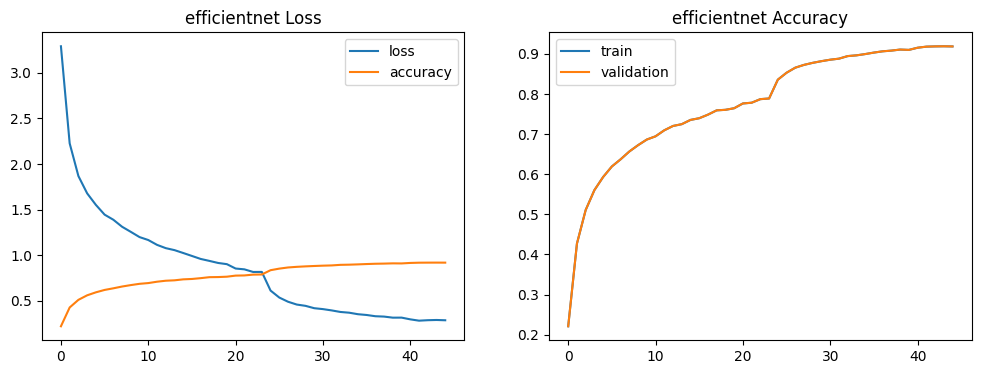

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, Model
import efficientnet.tfkeras as efn
import tensorflow as tf
from tensorflow.keras.callbacks import CSVLogger


size = 100
# Load and preprocess the data
(x_train, y_train), (x_test, y_test) = cifar100.load_data(
    label_mode="fine")



x_train = tf.image.resize(x_train, (size, size))
x_test = tf.image.resize(x_test, (size, size))

x_train = x_train / 255.0
x_test = x_test / 255.0

y_train = to_categorical(y_train, 100)
y_test = to_categorical(y_test, 100)

# Create data augmentation generator
data_gen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.25,
    height_shift_range=0.25,
    horizontal_flip=True,
    zoom_range=0.2
)
data_gen.fit(x_train)

efficientnet = efn.EfficientNetB4(weights='imagenet', include_top=False, input_shape=(size, size, 3))

# Add a custom classification head
x = layers.GlobalAveragePooling2D()(efficientnet.output)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.6)(x)
predictions = layers.Dense(100, activation='softmax')(x)

# Create the combined model
combined_model = Model(inputs=efficientnet.input, outputs=predictions)

opt = Adam(learning_rate=0.001)
combined_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Set up the callbacks
os.makedirs("checkpoints", exist_ok=True)
os.makedirs("plots", exist_ok=True)

checkpoint = ModelCheckpoint("checkpoints/weights.{epoch:02d}.hdf5", save_freq=20)
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=1, verbose=1, min_lr=1e-8)
early_stopping = EarlyStopping(monitor='loss', patience=3, verbose=1)
csv_logger = CSVLogger("plots/training_log.csv")

# Train the model
history = combined_model.fit(
    data_gen.flow(x_train, y_train, batch_size=64),
    epochs=100,
    verbose=1,
    steps_per_epoch=len(x_train) // 64,
    callbacks=[checkpoint, reduce_lr, early_stopping, csv_logger]
)

# Save the final model
combined_model.save("efficientnetfinetunedB3.h5")

# Plot the learning curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(history.history['loss'], label='loss')
ax1.plot(history.history['accuracy'], label='accuracy')
ax1.set_title('efficientnet Loss')
ax1.legend()

ax2.plot(history.history['accuracy'], label='train')
ax2.plot(history.history['accuracy'], label='validation')
ax2.set_title('efficientnet Accuracy')
ax2.legend()

plt.savefig("plots/learning_curves.png")

test_loss, test_accuracy = combined_model.evaluate(x_test, y_test)
print(f"Test loss: {test_loss}, Test accuracy: {test_accuracy}")